# SARIMAX load and generation forecast

In [1]:
project_home = %env PROJECT_HOME
%cd $project_home

F:\ai_voucher\MeritOrderPrediction


In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px
from math import sqrt
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# References

## https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
## https://machinelearningmastery.com/make-sample-forecasts-arima-python/
## http://www.reiter1.com/Glossar/ARIMA.htm
## https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Load forecasting

### Read in load data

In [5]:
data = pd.read_csv("./data/load_data.csv",
                   header=[0],
                   index_col=0,
                   parse_dates=True
                  )

data.index = pd.to_datetime(data.index,
                            utc=True
                           ).tz_convert(tz="Europe/Berlin")

In [6]:
data = data["2020-01-01":"2020-12-31"].resample("1H").mean() # resample data to 1 hour resolution

### make auto-correlation 

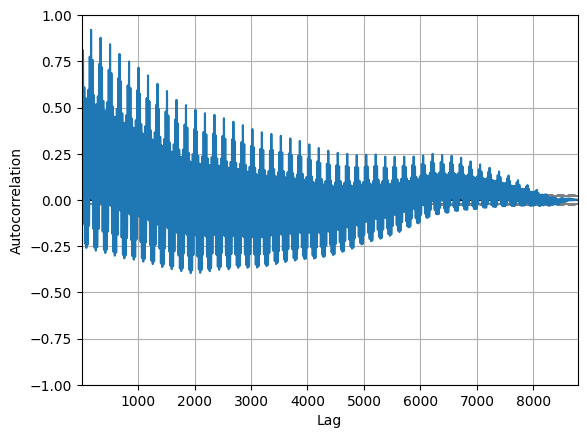

In [7]:
autocorrelation_plot(data)
plt.show()

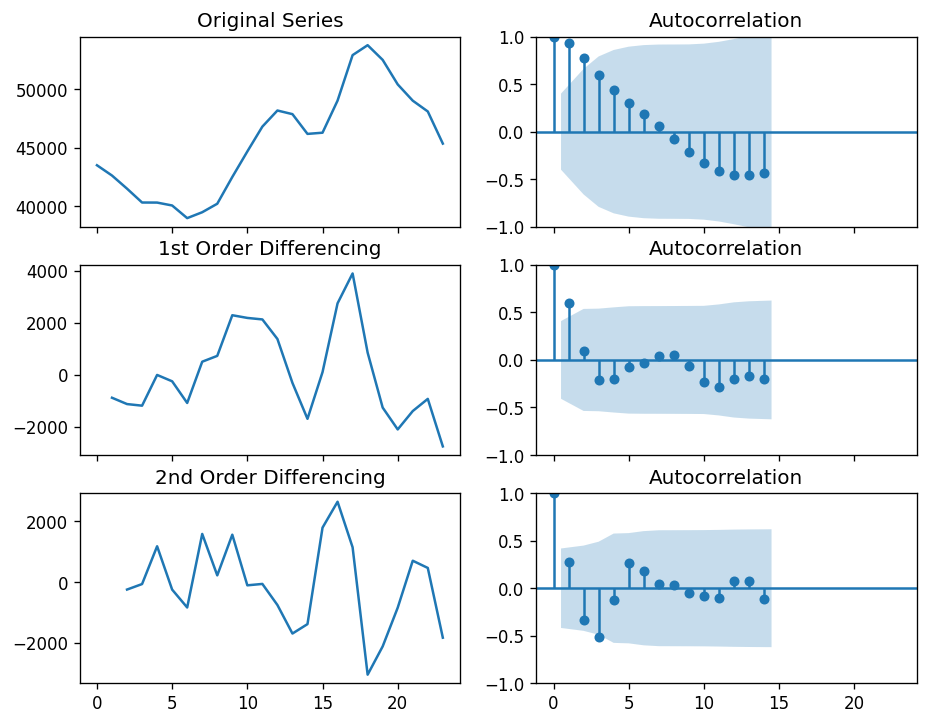

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data["2020-01-01":"2020-01-01"].values); axes[0, 0].set_title('Original Series')
plot_acf(data["2020-01-01":"2020-01-01"].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data["2020-01-01":"2020-01-01"].diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data["2020-01-01":"2020-01-01"].diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data["2020-01-01":"2020-01-01"].diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data["2020-01-01":"2020-01-01"].diff().diff().dropna().values, ax=axes[2, 1])

plt.show()

## Hyperparameter 

In [10]:
y = data["2020-01-01":"2020-01-01"].values

In [11]:
## Adf Test
p = ndiffs(y, test='adf') 
p

2

In [12]:
# KPSS test
d = ndiffs(y, test='kpss')  
d

1

In [13]:
# PP test:
q = ndiffs(y, test='pp')  
q

2

# Load prediction model

### define train and test dataset

In [26]:
train = data["2020-01-01":"2020-01-07"]
test = data["2020-01-08":"2020-01-14"]

### make predictions

In [27]:
predictions = pd.DataFrame()
MAPE = []
MAE = []
RMSE = []

# iterate through the test dataset,day by day
for i in range(0, len(test),24):
    start = test.index[i]
    end = test.index[i+23]
    
    # train the model
    
#    "The (P,D,Q,s) order of the seasonal component of the model 
#    for the AR parameters, differences, MA parameters, and periodicity. 
#    D must be an integer indicating the integration order of the process, 
#    while P and Q may either be an integers indicating the AR and MA orders 
#    (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. 
#    s is an integer giving the periodicity (number of periods in season), 
#    often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect." 
    
#    [https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html]
    
    model = SARIMAX(train, order=(p,d,q), seasonal_order=(2,1,2,24))
    
    # fit the model
    model_fit = model.fit()
    
    # make prediction from start to end index
    forecast = model_fit.predict(start, end)  # 95% conf
    #forecast = model_fit.predict(start, end)
    
    # add predictions to result dataframe
    predictions = pd.concat([predictions, forecast], axis=0)
    
    # observed data for the prediction period
    obs = test[start:end]
    
    # add oberserved data to the training set for training before the next prediction period
    train = pd.concat([train, obs], axis=0)
    
    print(model_fit.summary())
    
    # evaluate forecasts
    mae = sqrt(mean_absolute_error(obs, forecast))
    print('Test MAE: %.3f' % mae)
    MAE.append(mae)
    
    rmse = sqrt(mean_squared_error(obs, forecast))
    print('Test RMSE: %.3f' % rmse)
    RMSE.append(rmse)
    
    mape = mean_absolute_percentage_error(obs, forecast)
    print('Test MAPE: %.3f' % mape)
    MAPE.append(mape)

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -1189.426
Date:                            Thu, 09 Feb 2023   AIC                           2396.852
Time:                                    13:36:18   BIC                           2423.518
Sample:                                01-01-2020   HQIC                          2407.688
                                     - 01-07-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3476      0.078     17.261      0.000       1.195       1.501
ar.L2         -0.5303      0.100   

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  192
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -1377.164
Date:                            Thu, 09 Feb 2023   AIC                           2772.329
Time:                                    13:36:27   BIC                           2800.391
Sample:                                01-01-2020   HQIC                          2783.718
                                     - 01-08-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3809      0.064     21.562      0.000       1.255       1.506
ar.L2         -0.5588      0.081   

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -1565.994
Date:                            Thu, 09 Feb 2023   AIC                           3149.988
Time:                                    13:36:36   BIC                           3179.258
Sample:                                01-01-2020   HQIC                          3161.844
                                     - 01-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3534      0.070     19.445      0.000       1.217       1.490
ar.L2         -0.5246      0.086   

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  240
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -1751.896
Date:                            Thu, 09 Feb 2023   AIC                           3521.791
Time:                                    13:36:46   BIC                           3552.127
Sample:                                01-01-2020   HQIC                          3534.048
                                     - 01-10-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3459      0.070     19.268      0.000       1.209       1.483
ar.L2         -0.5172      0.086   

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  264
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -1978.012
Date:                            Thu, 09 Feb 2023   AIC                           3974.023
Time:                                    13:36:56   BIC                           4005.311
Sample:                                01-01-2020   HQIC                          3986.632
                                     - 01-11-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0526      0.120     -0.436      0.663      -0.289       0.184
ar.L2         -0.1550      0.101   

C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                  288
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -2167.004
Date:                            Thu, 09 Feb 2023   AIC                           4352.008
Time:                                    13:37:07   BIC                           4384.157
Sample:                                01-01-2020   HQIC                          4364.928
                                     - 01-12-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0118      0.116      0.102      0.919      -0.216       0.239
ar.L2         -0.1491      0.091   

## Plot the SARIMAX load forecasting results

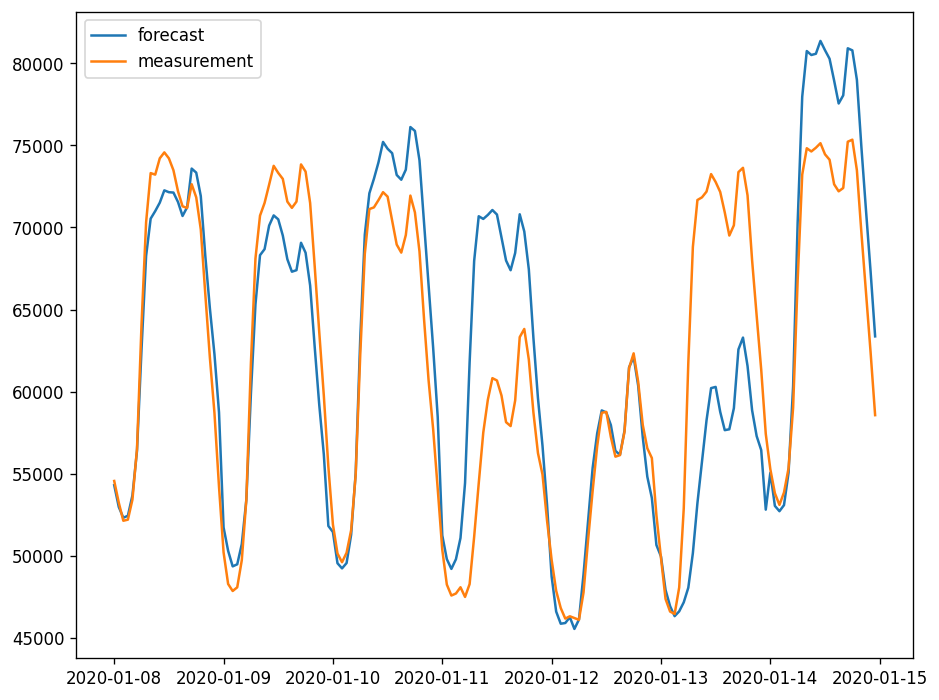

In [28]:
plt.plot(predictions)
plt.plot(test)
plt.legend(["forecast", "measurement"])

# Generation type forecasting

## Read in generation data

In [35]:
data_gen = pd.DataFrame()
data_gen = pd.read_csv("./data/entsoe_gen.csv",
                   header=[0],
                   index_col=0,
                   decimal=",",
                   low_memory=False,
                  ).drop(
    ['Fossil Gas.1',
     'Fossil Oil.1',
     'Hydro Water Reservoir.1',
     'Nuclear.1',
     'Other renewable.1',
     'Solar.1',
     'Wind Onshore.1'],
    axis=1,
)

data_gen.drop(index=data_gen.index[0], axis=0, inplace=True)

data_gen.index = pd.to_datetime(data_gen.index,
                                    utc=True
                                    ).tz_convert(tz="Europe/Berlin")

In [36]:
data_gen = data_gen.astype(float)

In [37]:
data_gen = data_gen["2020-01-01":"2020-01-31"].resample("1H").mean()

In [38]:
def find_hyperparameter(y):
    ## Adf Test
    p = ndiffs(y, test='adf') 
    # KPSS test
    d = ndiffs(y, test='kpss')  
    # PP test:
    q = ndiffs(y, test='pp')  

    print("p=",p, " d=",d, " q=", q)
    
    return p, d, q

## Make generation prediction of all different generation types

In [39]:
Predictions = pd.DataFrame()
MAPE = pd.DataFrame()
MAE = pd.DataFrame()
RMSE = pd.DataFrame()
Observed = pd.DataFrame()

for col in data_gen.columns:
    predictions = pd.DataFrame()
    mape_ = []
    rmse_ = []
    mae_ = []

    train = data_gen[col]["2020-01-01":"2020-01-07"]
    test = data_gen[col]["2020-01-08":"2020-01-10"]
    
    p,d,q = find_hyperparameter(train["2020-01-01":"2020-01-01"])

    # iterate through the test dataset,day by day
    for i in range(0, len(test),24):
        start = test.index[i]
        end = test.index[i+23]

        # train the model order=(AR,I,MA)
        model = SARIMAX(train, order=(p,d,q), seasonal_order=(2,1,2,24))

        # fit the model
        model_fit = model.fit()

        # make prediction from start to end index
        forecast = model_fit.predict(start, end)

        # add predictions to result dataframe
        predictions = pd.concat([predictions, forecast], axis=0)

        # observed data for the prediction period
        obs = test[start:end]

        # add oberserved data to the training set for training before the next prediction period
        train = pd.concat([train, obs], axis=0)

        # evaluate forecasts
        mae = sqrt(mean_absolute_error(obs, forecast))
        print('Test MAE: %.3f' % mae)
        mae_.append(mae)

        rmse = sqrt(mean_squared_error(obs, forecast))
        print('Test RMSE: %.3f' % rmse)
        rmse_.append(rmse)

        mape = mean_absolute_percentage_error(obs, forecast)
        print('Test MAPE: %.3f' % mape)
        mape_.append(mape)
    
    Predictions[col] = predictions
    Observed[col] = test
    MAPE[col] = mape_
    MAE[col] = mae_
    RMSE[col] = rmse_


p= 2  d= 1  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

Test MAE: 6.369
Test RMSE: 49.208
Test MAPE: 0.008


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Test MAE: 5.878
Test RMSE: 41.652
Test MAPE: 0.007


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Test MAE: 7.047
Test RMSE: 55.543
Test MAPE: 0.010
p= 2  d= 1  q= 1


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

Test MAE: 46.317
Test RMSE: 2213.463
Test MAPE: 0.196


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-inverti

Test MAE: 46.606
Test RMSE: 2524.710
Test MAPE: 0.196


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Test MAE: 22.314
Test RMSE: 593.998
Test MAPE: 0.044
p= 2  d= 1  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 67.792
Test RMSE: 5030.294
Test MAPE: 0.502


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 64.014
Test RMSE: 4637.541
Test MAPE: 0.548


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 31.152
Test RMSE: 1103.548
Test MAPE: 0.125
p= 2  d= 0  q= 1


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 36.331
Test RMSE: 1764.189
Test MAPE: 0.136


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 64.844
Test RMSE: 4552.436
Test MAPE: 0.677


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 30.583
Test RMSE: 1136.141
Test MAPE: 0.151
p= 1  d= 0  q= 0


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Test MAE: 6.375
Test RMSE: 71.476
Test MAPE: 0.085


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 8.073
Test RMSE: 66.053
Test MAPE: 0.139


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 2.867
Test RMSE: 10.057
Test MAPE: 0.018
p= 2  d= 2  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 0.934
Test RMSE: 1.169
Test MAPE: 0.033


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 1.934
Test RMSE: 4.866
Test MAPE: 0.177


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 1.248
Test RMSE: 1.804
Test MAPE: 0.064
p= 2  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 18.237
Test RMSE: 410.607
Test MAPE: 0.352


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 25.509
Test RMSE: 728.939
Test MAPE: 4.019


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 16.834
Test RMSE: 393.376
Test MAPE: 0.609
p= 0  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 30.209
Test RMSE: 1074.797
Test MAPE: 5.231


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 27.381
Test RMSE: 915.010
Test MAPE: 1.536


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 24.502
Test RMSE: 759.774
Test MAPE: 0.876
p= 2  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 4.276
Test RMSE: 23.378
Test MAPE: 0.013


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 7.385
Test RMSE: 64.951
Test MAPE: 0.039


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 7.097
Test RMSE: 55.100
Test MAPE: 0.037
p= 1  d= 0  q= 0


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 6.311
Test RMSE: 46.997
Test MAPE: 0.745


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 6.012
Test RMSE: 40.425
Test MAPE: 1.326


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 6.752
Test RMSE: 59.534
Test MAPE: 0.831
p= 2  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 14.186
Test RMSE: 223.084
Test MAPE: 0.026


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 9.602
Test RMSE: 108.922
Test MAPE: 0.012


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 14.263
Test RMSE: 285.435
Test MAPE: 0.027
p= 1  d= 1  q= 1


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Test MAE: 4.052
Test RMSE: 19.022
Test MAPE: 0.039


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 5.621
Test RMSE: 34.807
Test MAPE: 0.075


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 3.723
Test RMSE: 16.707
Test MAPE: 0.035
p= 0  d= 0  q= 1


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 1.962
Test RMSE: 6.146
Test MAPE: 0.022


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Test MAE: 2.603
Test RMSE: 9.537
Test MAPE: 0.038


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Test MAE: 3.810
Test RMSE: 16.715
Test MAPE: 0.084
p= 2  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 18.865
Test RMSE: 663.189
Test MAPE: 56457842871808352.000


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 17.555
Test RMSE: 610.428
Test MAPE: 27595937103967724.000


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 17.616
Test RMSE: 631.401
Test MAPE: 5372106556554880.000
p= 1  d= 0  q= 0


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Test MAE: 2.723
Test RMSE: 9.595
Test MAPE: 0.009


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 3.938
Test RMSE: 22.487
Test MAPE: 0.019


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 4.281
Test RMSE: 24.487
Test MAPE: 0.023
p= 1  d= 1  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Test MAE: 45.713
Test RMSE: 2760.922
Test MAPE: 0.946


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 51.789
Test RMSE: 3139.746
Test MAPE: 0.813


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 40.746
Test RMSE: 2044.123
Test MAPE: 0.450
p= 2  d= 0  q= 2


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 75.487
Test RMSE: 8955.768
Test MAPE: 0.520


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Test MAE: 134.625
Test RMSE: 19394.986
Test MAPE: 1.000


C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\Merrit_Order\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 37.121
Test RMSE: 1569.875
Test MAPE: 0.064


# Plot results for all diffenrent generation types 

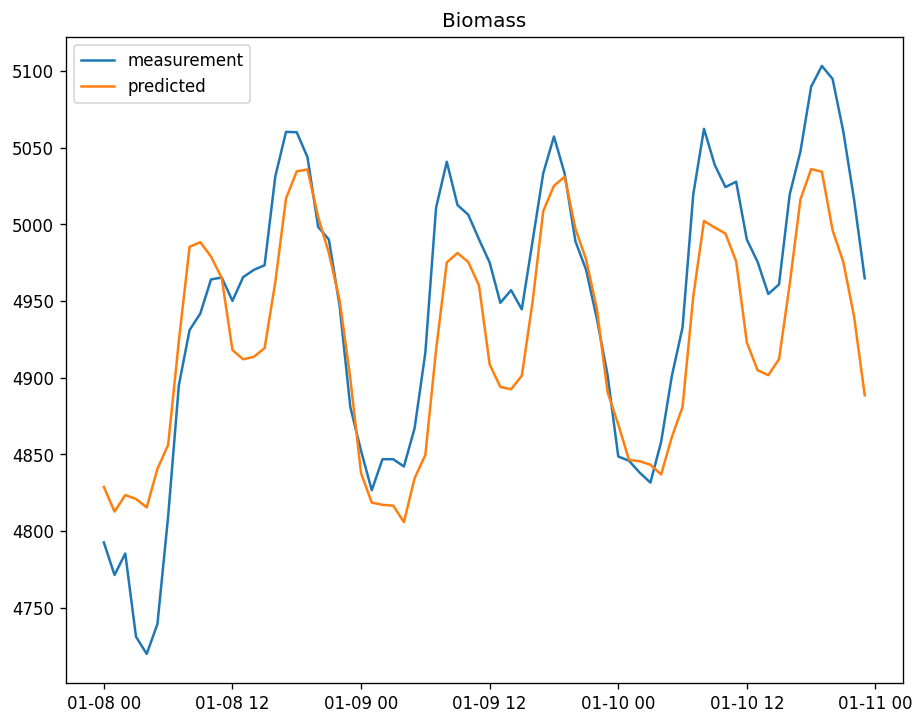

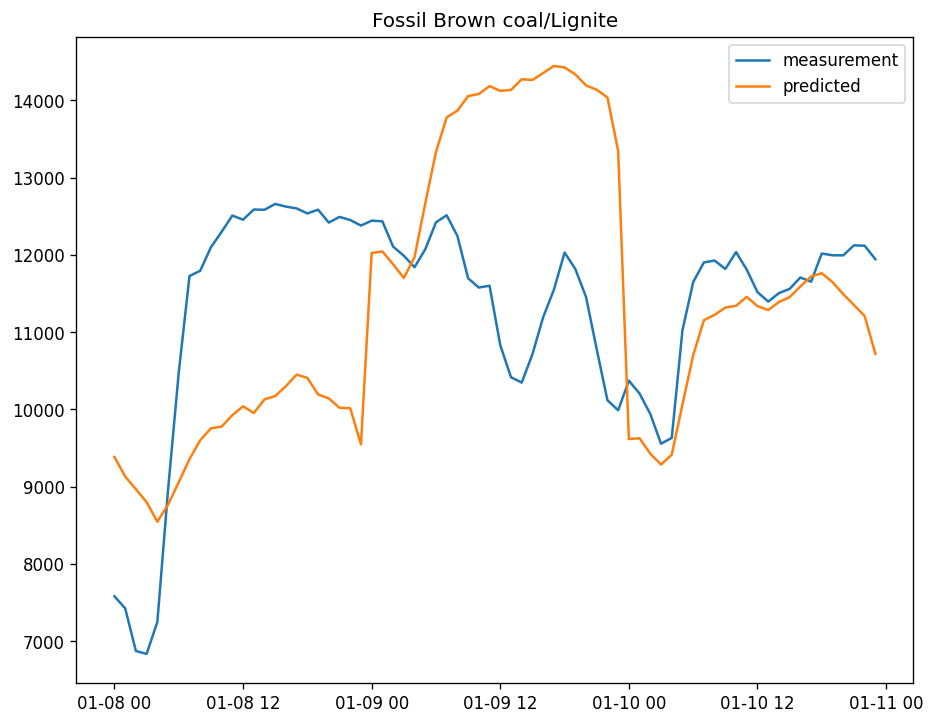

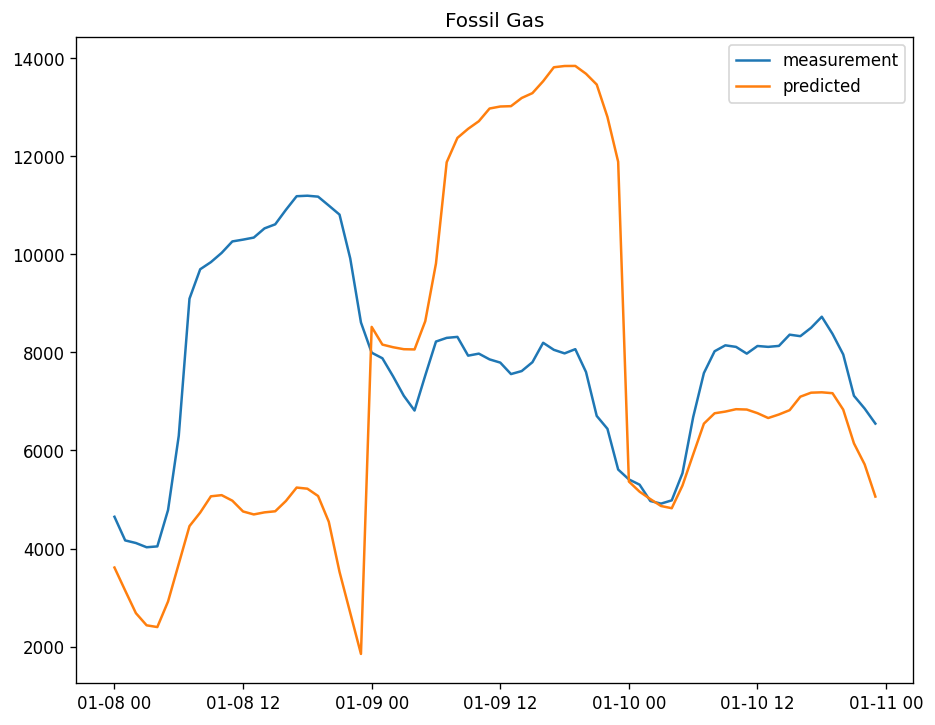

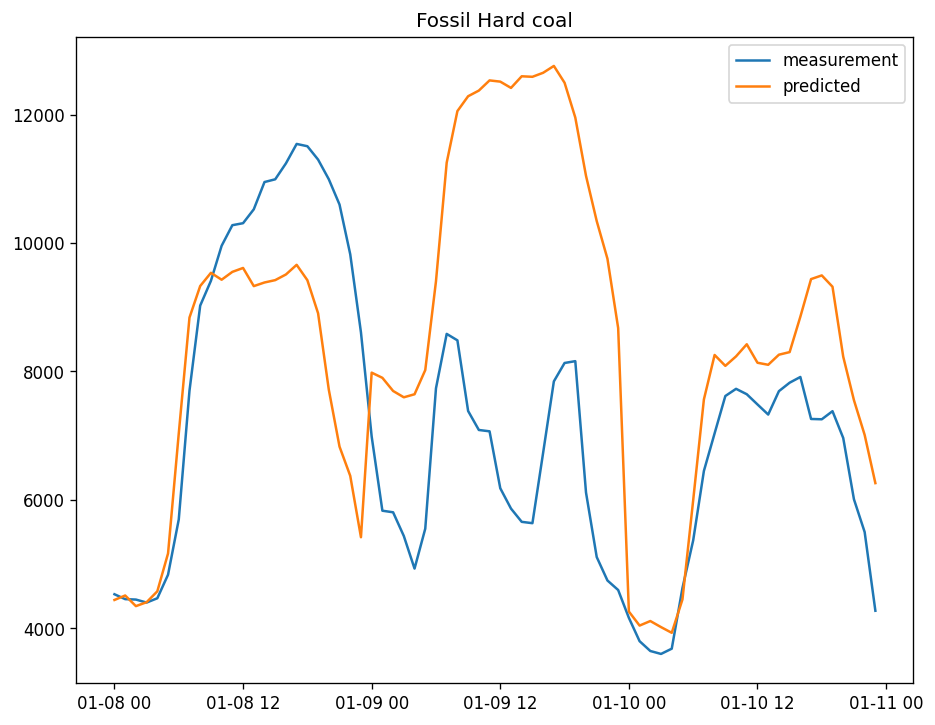

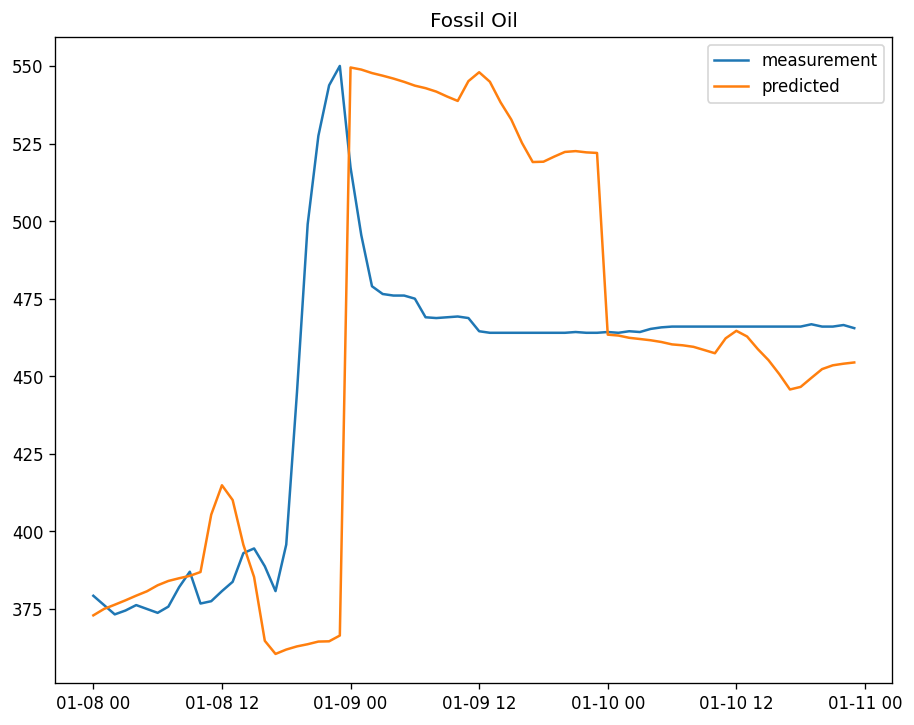

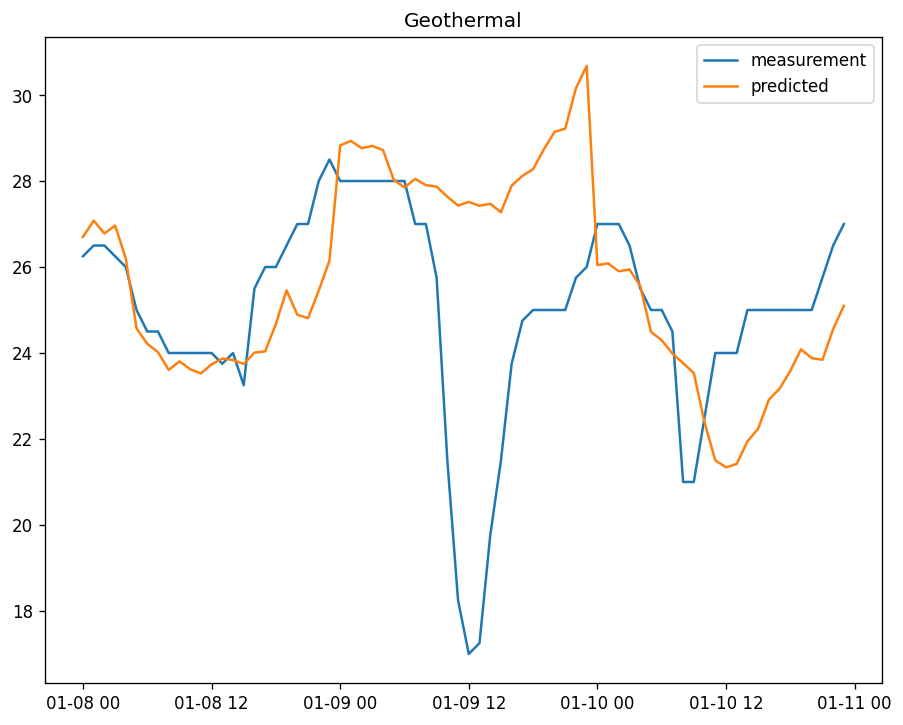

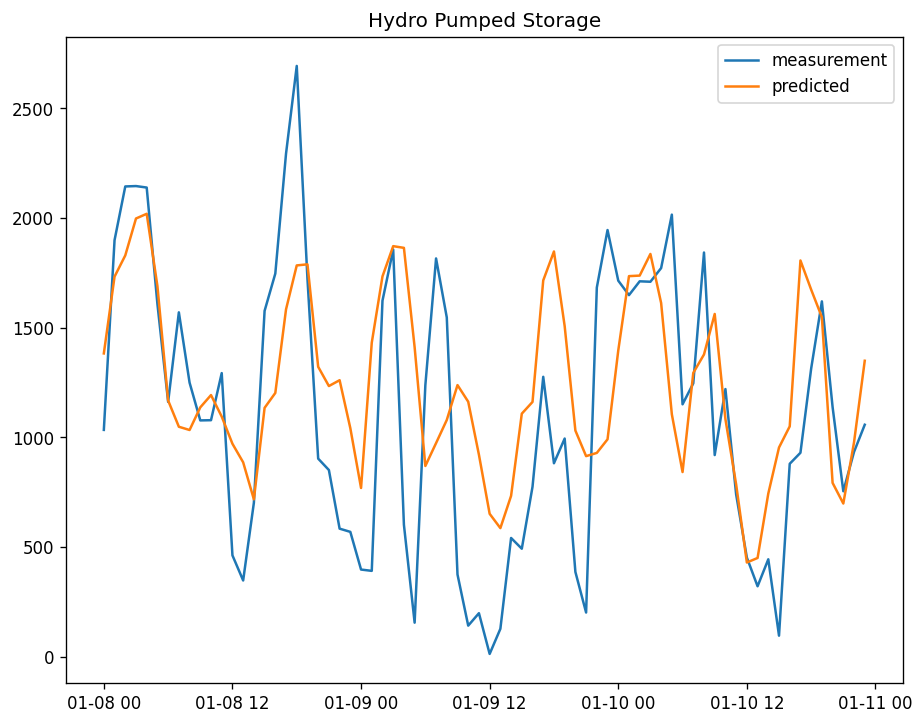

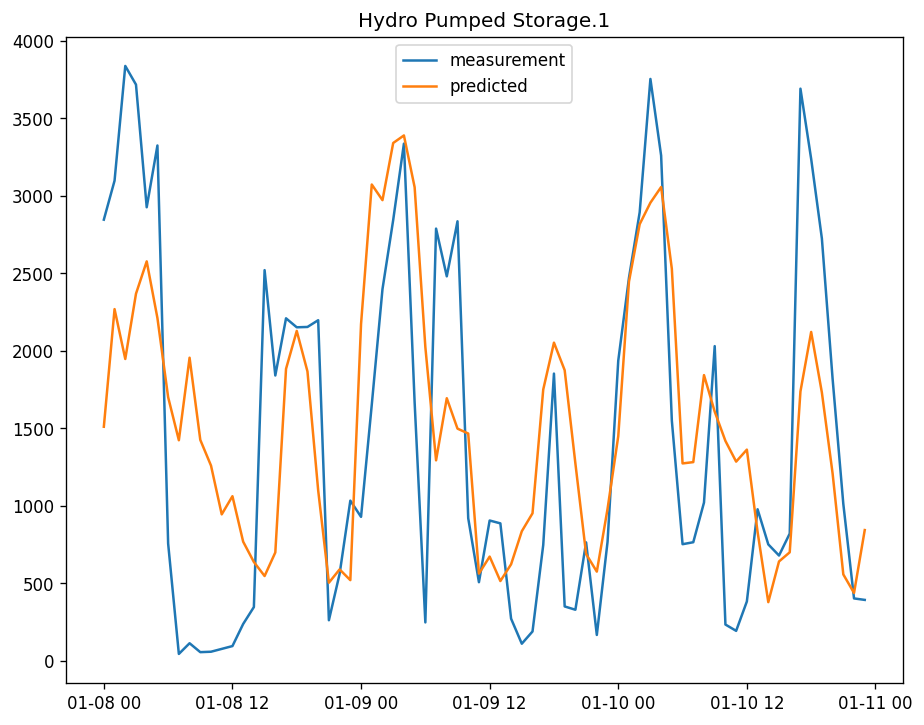

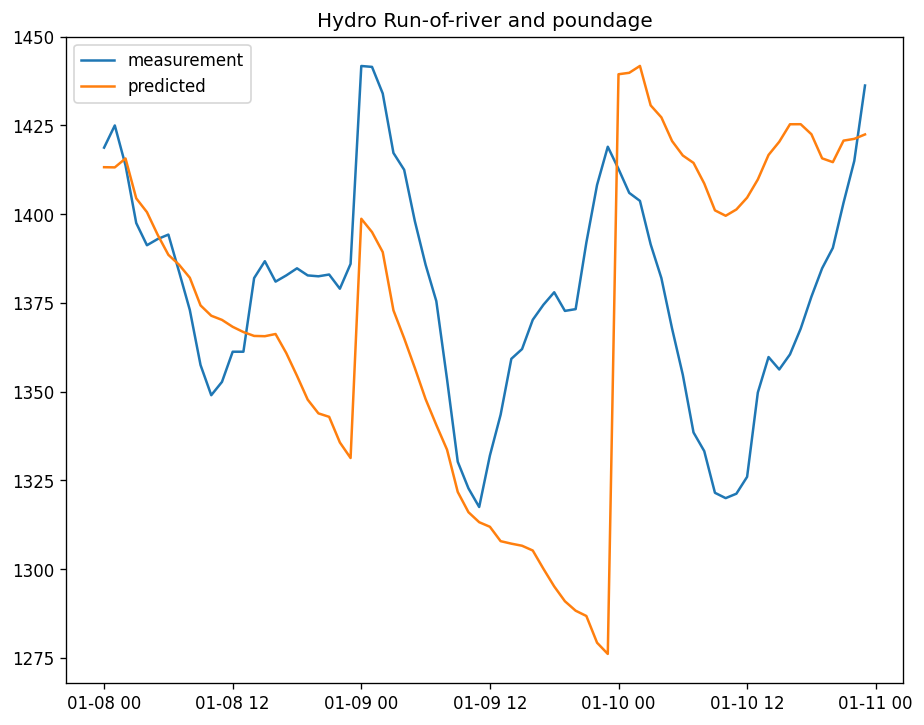

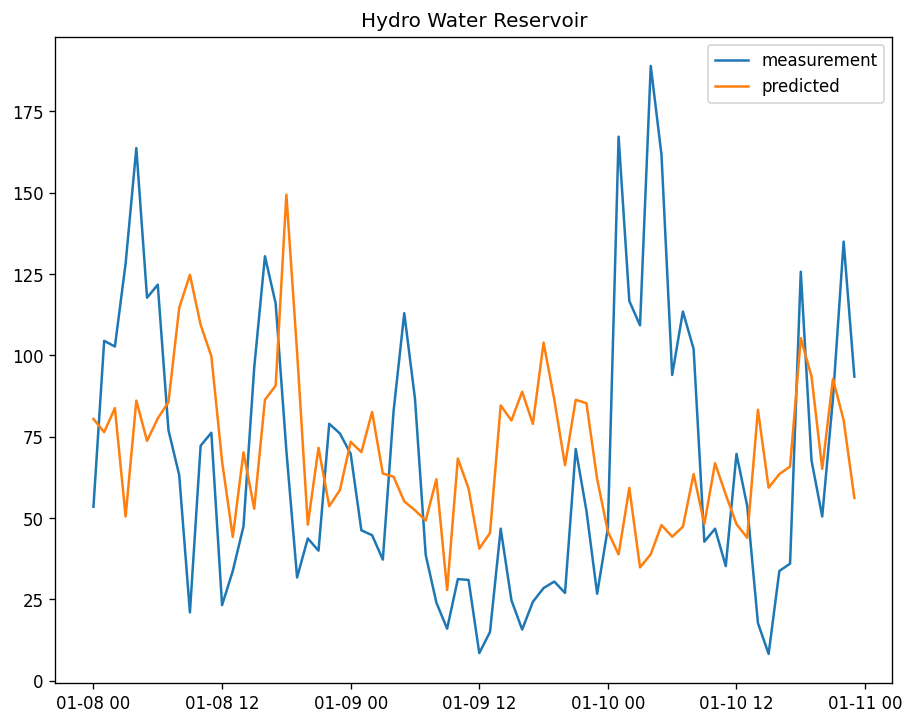

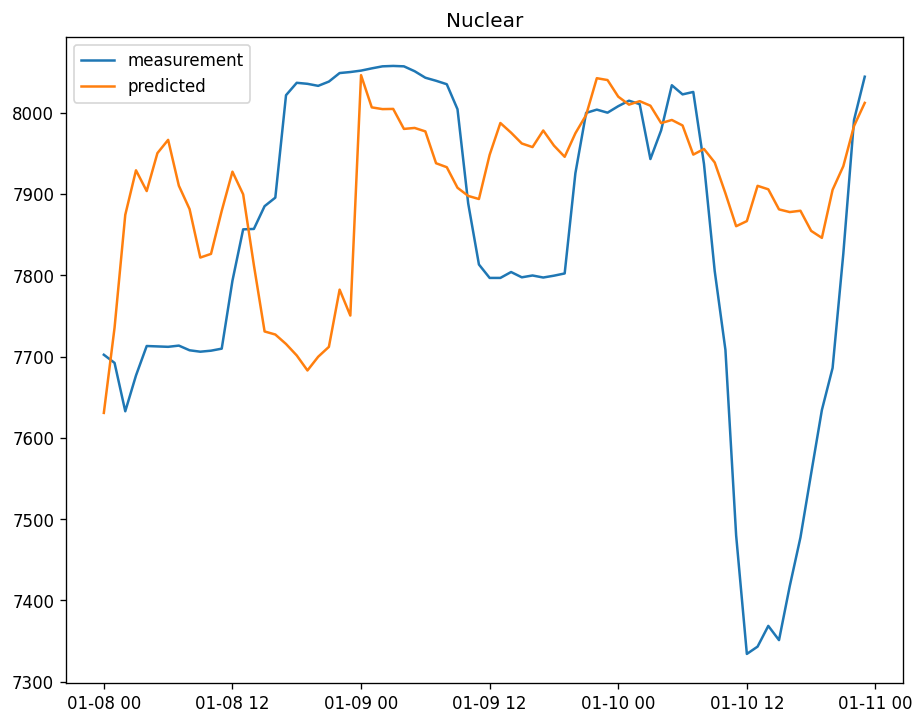

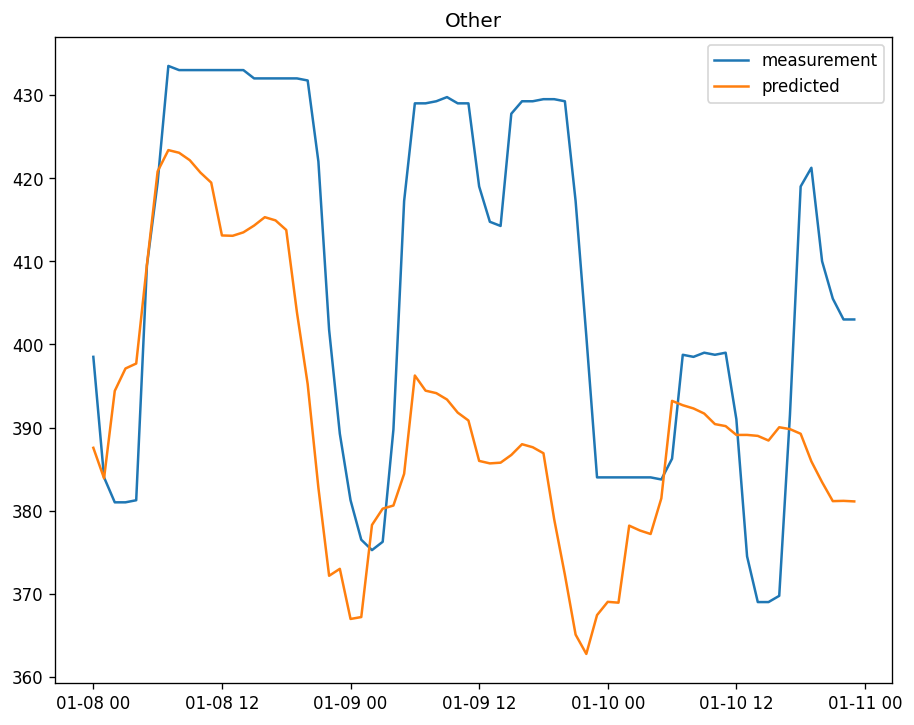

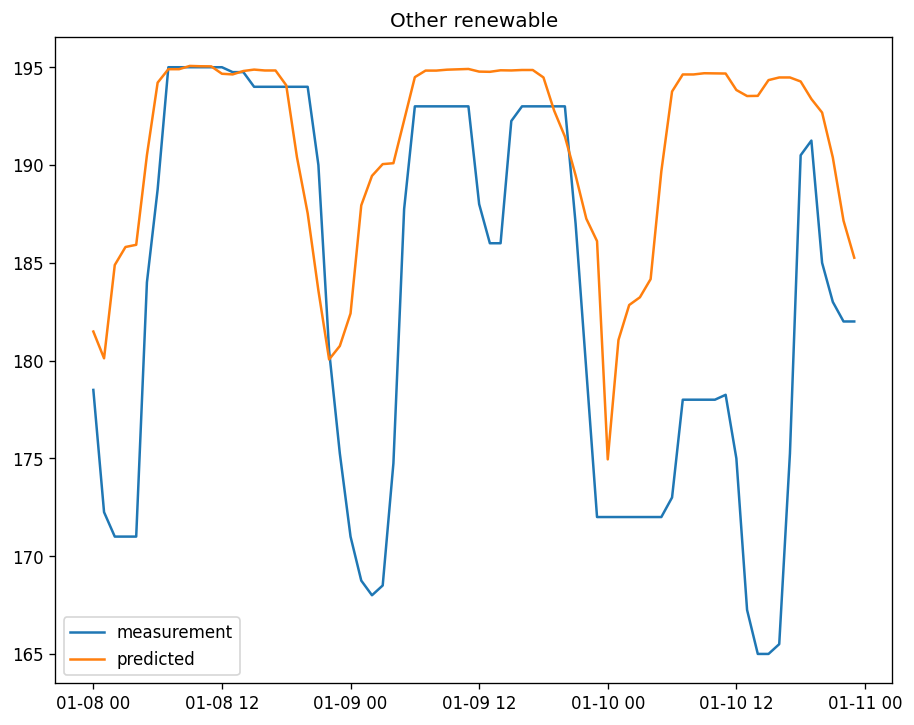

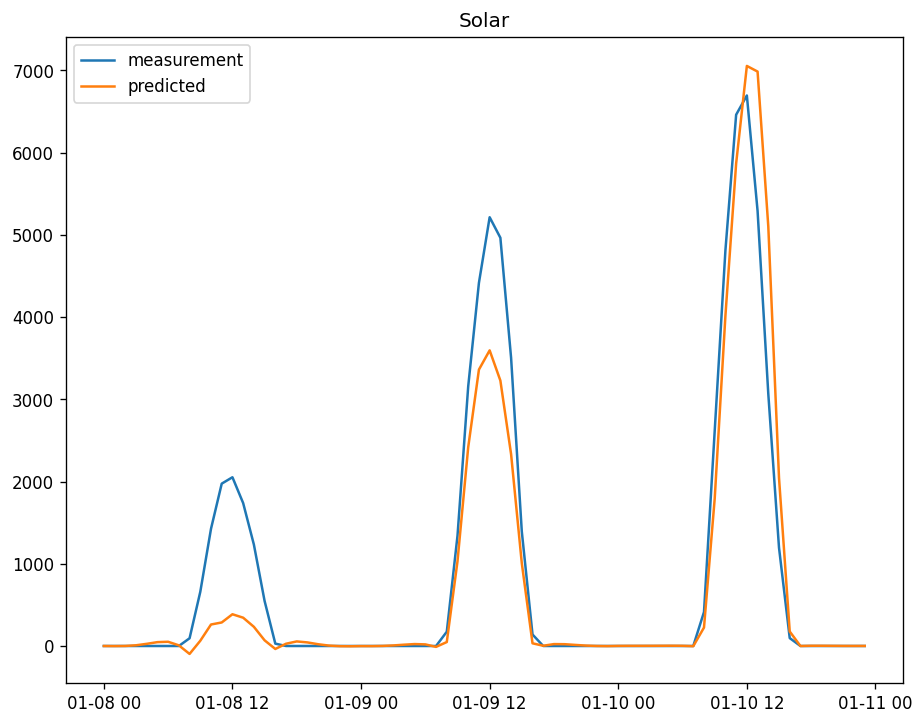

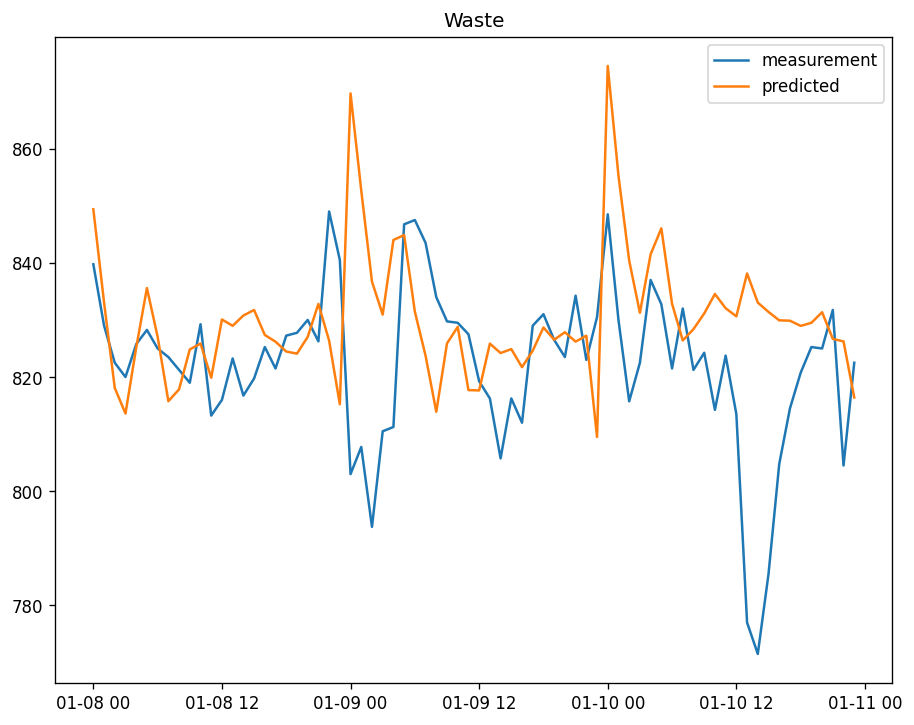

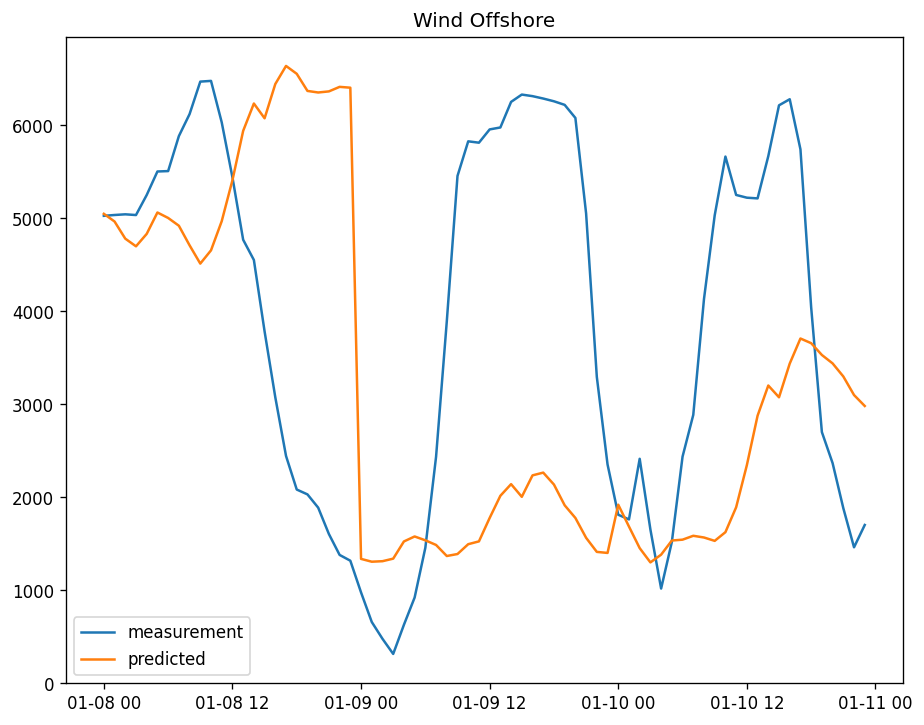

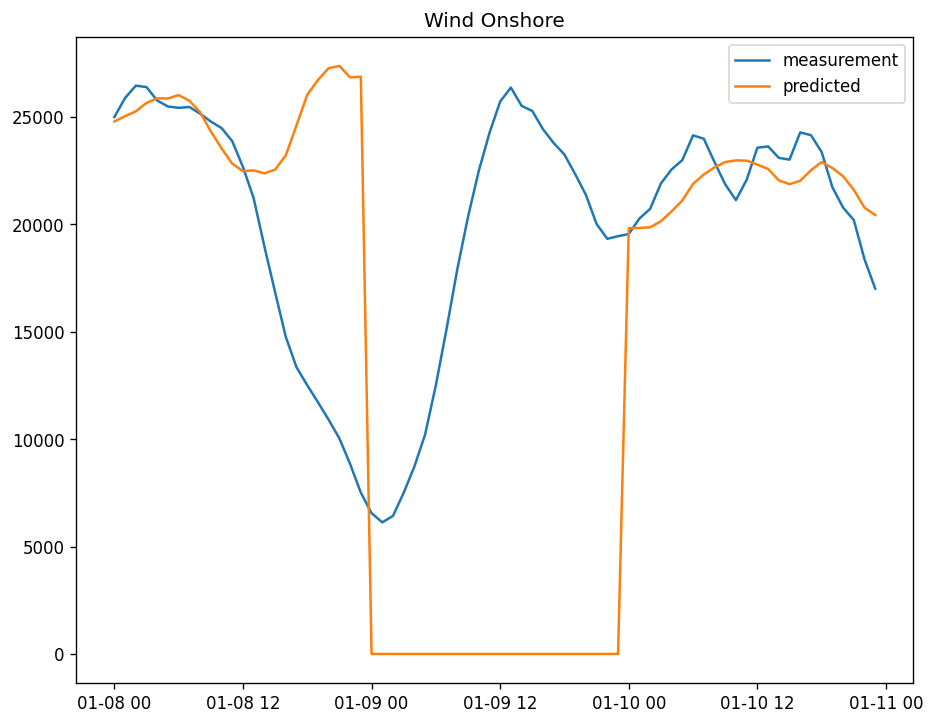

In [40]:
for col in Predictions.columns:
    plt.plot(Observed[col])
    plt.plot(Predictions[col])
    plt.legend(["measurement", "predicted"])
    plt.title(col)
    plt.show()